In [3]:
import pymysql
# 取得需要进行分析的数据
try:
    connection = pymysql.connect(host='116.63.167.124',  # host属性
                                 user='root',  # 用户名
                                 password='',  # 此处填登录数据库的密码
                                 db='job_database'  # 数据库名
                                 )
    # 使用 cursor() 方法创建一个游标对象 cursor
    cursor = connection.cursor()
    # 使用 execute()  方法执行 SQL 查询
    cursor.execute("SELECT * FROM job_table WHERE job_name like '%%' and job_academic like '%%' and job_city like '%%'")
    # 使用 fetchone() 方法获取单条数据.
    data = cursor.fetchall()
    connection.close()
except:
    # 发生错误时回滚
    print("none")
if len(data) > 0:
    print(len(data))

27628


In [4]:
import re

# 载入data中的detail_result列并将所有的数据进行载入成一列数据列表之后
def update(data):
    all_data =  [detail[17] for detail in data]#读入全部数据训练模型
    lines = []
    for i in range(len(all_data)): #分别对每段分词
        line = []
        if all_data[i] is not None:
            temp = re.finditer('(?!([0-9. -]))[\u4e00-\u9fa5/a-zA-Z0-9 +.-/#-]+', all_data[i])
            for word in temp:
                # 去除chatgpt返回的以技术开头的词汇
                if not word.group().startswith("技"):
                    line.append(word.group().replace(' ', ''))
            lines.append(line)
        else:
            lines.append(line)
    return lines

In [5]:
import jieba
import re
import numpy as np
# 读取停用词列表
def get_stopword_list(file):
    with open(file, 'r', encoding='utf-8') as f:    # 
        stopword_list = [word.strip('\n') for word in f.readlines()]
    return stopword_list


# 分词 然后清除停用词语
def clean_stopword(string, stopword_list):
    result = ''
    # stopword_list.append('erp')
    if string not in stopword_list:
    # 将所有不在停用词表中的词汇留下并将其中所有的大写字母转换成小写便于统计
        result += string.lower()
    return result

In [6]:
def clean(lines):
    # 可在停用词表中添加自己不想留下的词汇
    stopword_file = './hit_stopwords.txt'
    stopword_list = get_stopword_list(stopword_file)    # 获得停用词列表
    result_list = []
    for i in range(len(lines)):
        result = []
        # 忽略空值进行训练数据
        if lines[i] is not None:  
            for temp in lines[i]:
                result.append(clean_stopword(temp, stopword_list))
            lines[i] = [temp for temp in result if temp]
    return lines

## 调用清理函数并生成训练

In [7]:
import gensim
from gensim.models import Word2Vec

# 得出训练词汇列表
lines = update(data)
# 清理停用词
lines = clean(lines)

# 调用Word2Vec训练
# 参数：size: 词向量维度；window: 上下文的宽度，min_count为考虑计算的单词的最低词频阈值
w2v_model = Word2Vec(lines, vector_size = 40, window = 2 , min_count = 2, epochs=7, negative=10,sg=1)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Gimes\AppData\Local\Temp\jieba.cache
Loading model cost 0.799 seconds.
Prefix dict has been built successfully.


In [16]:
w2v_model.wv.most_similar("mysql", topn = 5)

[('postgresql', 0.8797929286956787),
 ('nosql', 0.8716303706169128),
 ('mysql等', 0.8520218729972839),
 ('synapse', 0.8494269251823425),
 ('nosql数据库', 0.8479032516479492)]

In [9]:
# 将模型保存到磁盘上
w2v_model.save('./word2vec/word2vec_model.bin')

# 加载模型

In [10]:
from gensim.models import Word2Vec
w2v_model = Word2Vec.load('./word2vec/word2vec_model.bin')

In [11]:
w2v_model.wv.most_similar("springcloud", topn = 10)

[('springsecurity', 0.9126679301261902),
 ('mybatis-plus', 0.9091512560844421),
 ('springcloudalibaba', 0.9073056578636169),
 ('spingcloud', 0.903237521648407),
 ('mybatisplus', 0.9022281765937805),
 ('springboot/cloud', 0.899379312992096),
 ('apacheshiro', 0.8977550268173218),
 ('java8', 0.8964625000953674),
 ('springdata', 0.8958907127380371),
 ('mybatis/jpa', 0.8935050964355469)]

[('mysql', 5004), ('java', 4737), ('python', 4144), ('c++', 3295), ('c#', 2997), ('oracle', 2968), ('javascript', 2886), ('linux', 2667), ('redis', 2444), ('sqlserver', 2374), ('css', 2223), ('sql', 2032), ('html', 2006), ('vue', 1919), ('沟通能力', 1912), ('springboot', 1879), ('数据分析', 1799), ('数据结构', 1769), ('c/c++', 1757), ('设计模式', 1737), ('数据库', 1704), ('jquery', 1660), ('算法', 1613), ('mybatis', 1605), ('多线程', 1541), ('spring', 1470), ('springcloud', 1357), ('git', 1331), ('软件开发', 1278), ('html5', 1268), ('opencv', 1258), ('学习能力', 1175), ('图像处理', 1114), ('springmvc', 1070), ('ajax', 1058), ('机器学习', 1032), ('团队合作', 963), ('深度学习', 919), ('net', 910), ('kafka', 901), ('mongodb', 898), ('react', 890), ('hadoop', 874), ('spark', 821), ('tensorflow', 808), ('qt', 778), ('软件工程师', 770), ('matlab', 763), ('halcon', 755), ('hive', 754), ('css3', 747), ('c语言', 718), ('c', 718), ('docker', 713), ('性能优化', 710), ('php', 704), ('js', 698), ('pytorch', 697), ('http', 681), ('责任心', 676), ('tcp/ip', 674

(-0.5, 1599.5, 1199.5, -0.5)

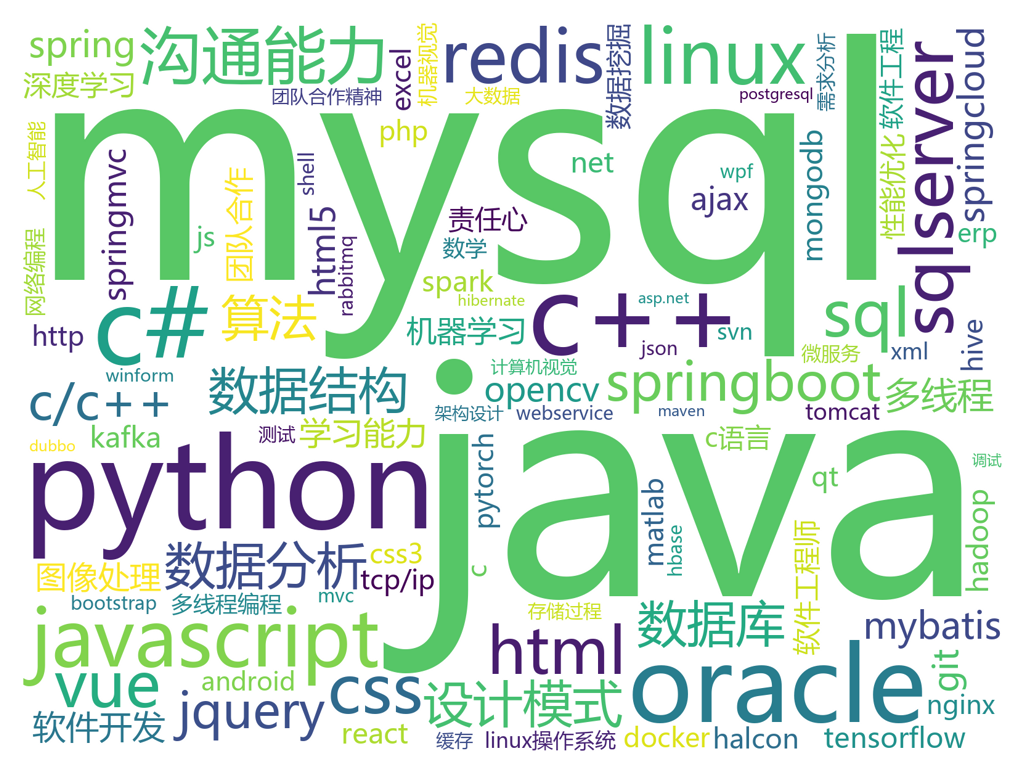

In [15]:
# 首先得出在未经相关词合并时的词数排序
from collections import Counter
words_counts = Counter()
for temp in lines:
    words_count = Counter(temp)
    words_counts += words_count
print(words_counts.most_common(100))

from wordcloud import WordCloud
fontpath='C:/Windows/Fonts/msyh.ttc' #当前字体文件为MAC下所有，如果WIN环境下，请替换文件路径

wc = WordCloud(font_path=fontpath,  # 设置字体
               background_color="white",  # 背景颜色
               max_words=1000,  # 词云显示的最大词数
               max_font_size=500,  # 字体最大值
               min_font_size=20, #字体最小值
               random_state=42, #随机数
               collocations=False, #避免重复单词
               width=1600,height=1200,margin=10, #图像宽高，字间距，需要配合下面的plt.figure(dpi=xx)放缩才有效
              )
# 从字典生成一个词云对象
wc.generate_from_frequencies(dict(words_counts.most_common(100)))    
import matplotlib.pyplot as plt
plt.figure(dpi=200) #通过这里可以放大或缩小
plt.imshow(wc, interpolation='catrom',vmax=1000)
plt.axis("off") #隐藏坐标

In [16]:
# 清洗数据详情的函数,传入值为待清洗的该列数据
def clean_detail(data):
    temp = jieba.lcut(data, cut_all=True, HMM=False)  #结巴分词 精确模式
    words = []
    for i in temp:
        #过滤掉所有的标点符号
        i = re.sub("[\s+\.\!\/_,$%^*(+\"\'””《》]+|[+——！，。？、~@#￥%……&*（）：；‘]+", "", i)
        #去除长度小于2的词汇         
        if len(i) > 2:
            words.append(i)
    stopword_file = './hit_stopwords.txt'
    stopword_list = get_stopword_list(stopword_file)    # 获得停用词列表
    result = []
    for temp in words:
        result.append(clean_stopword(temp, stopword_list))
    result = list(dict.fromkeys(result))
    set = []
    for word in result: 
        try:
            temp = model.wv.most_similar(word, topn = 1)[0][1]
            if temp >= 0.95:
                set.append(word)
        except:
            continue
    clean_detail = set
    return clean_detail